In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import json

from tqdm.notebook import tqdm

from collections import defaultdict
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
import pickle

def get_path(filename):
  return f'/content/drive/MyDrive/Data/{filename}'

def get_data_from_pickle(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data

In [ ]:
def write_data_to_pickle(data, path):
    with open(path, "wb") as f:
        f.write(pickle.dumps(data))

In [ ]:
tag_vectors = get_data_from_pickle(get_path('tag_vectors'))
cluster_centers = get_data_from_pickle(get_path('kmeans15.cluster_centers_.pickle'))
unique_tag_list = get_data_from_pickle(get_path('unique_tag_list.pickle'))
tag_dict = get_data_from_pickle(get_path('tag_dict.pickle'))

In [ ]:
df_meta = pd.read_csv(get_path('Meta_v1.csv'))
# df = pd.read_json(get_path('data_version_2.json'))

In [ ]:
tag_matrix = np.array(tag_vectors)

In [ ]:
tag2idx = {tag: i for i, tag in enumerate(unique_tag_list)}
idx2tag = {i: tag for i, tag in enumerate(unique_tag_list)}

df = df.reset_index(drop=True)

unique_songs = list(set([song for songs in df.songs2 for song in songs]))

song_idx2new_idx = {song_id: idx for idx, song_id in enumerate(unique_songs)}
new_idx2song_idx = {idx: song_id for idx, song_id in enumerate(unique_songs)}


genres_set = list(set([genre for genres in df_meta.gnrs for genre in genres]))

df_meta['new_id'] = df_meta.id.map(lambda x: song_idx2new_idx.get(int(x)))

In [ ]:
df

,tags,id,plylst_title,songs,like_cnt,updt_date,len,tag_len,songs2,song2_len
0,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,28,2,"[83116, 276692, 166267, 354465, 256598, 666852...",25
1,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...",69252,2017 Pop Trend,"[418694, 222305, 96545, 135950, 304687, 457451...",435,2017-09-15 15:59:26.000,30,10,"[418694, 222305, 96545, 135950, 304687, 457451...",22
2,"[잔잔한, 추억, 회상]",36557,멍청이.. 내맘도 몰라.,"[496913, 632529, 501426, 515574, 411161, 10341...",5,2008-09-23 22:32:02.000,20,3,"[632529, 501426, 515574, 411161, 103411, 17813...",17
3,"[우울, 힐링, 힘내]",112060,지친 너를 위로해줄 제목편지 준비해봤어,"[449808, 691770, 640657, 313395, 697100, 34090...",1,2018-01-04 22:49:29.000,21,3,"[691770, 640657, 313395, 697100, 340905, 22169...",15
4,[비오는날],75342,"이렇게 비 내리는 날이면, 너도 내 생각 할까..","[379674, 164522, 33196, 281228, 640012, 117969...",17,2016-10-12 16:22:17.000,18,1,"[164522, 33196, 640012, 117969, 75425, 627363,...",15
...,...,...,...,...,...,...,...,...,...,...
29349,"[겨울, 설렘, 사랑]",133185,첫눈처럼 설레였던 그날♥,"[334564, 221618, 504089, 321512, 476845, 11368...",154,2014-12-24 14:25:23.000,25,3,"[334564, 221618, 476845, 113687, 211159, 51275...",21
29350,[팝],33486,들을수록 걸크러쉬 물씬 느껴지는 음악리스트,"[619719, 374517, 323561, 79157, 170970, 241952...",4,2017-03-18 00:07:08.000,29,1,"[619719, 374517, 323561, 79157, 241952, 587512...",17
29351,[인디],153220,오후의 어쿠스틱 vol.2,"[627005, 253230, 643932, 22659, 316149, 247137...",39,2013-04-19 01:36:45.000,21,1,"[627005, 253230, 643932, 22659, 316149, 247137...",20
29352,[여친],79538,여자친구 명곡,"[65053, 389127, 443914, 498028, 375431, 312296...",6,2018-03-09 14:24:37.000,23,1,"[65053, 389127, 443914, 498028, 375431, 312296...",23


In [ ]:
df['tagIds'] = df.tags.map(lambda x: [tag2idx.get(tag) for tag in x])

tag_cluster_ids = [
    [tag2idx[tag] for tag in tag_dict[key]]
    for key in range(15)
]

min_tag_count = 2

df_clusters = [
    df[df.tagIds.map(lambda x: np.intersect1d(tag_cluster_ids[key], x, assume_unique=True).shape[0] >= min_tag_count )]
    for key in range(15)
]

cluster_songs = []

for key in range(15):
    cluster_songs.append(list(set([song for songs in df_clusters[key].songs2 for song in songs])))
    print(f"{key} : {df_clusters[key].shape} / {len(cluster_songs[key])}")

0 : (780, 11) / 9685
1 : (228, 11) / 3987
2 : (999, 11) / 8014
3 : (144, 11) / 852
4 : (843, 11) / 9806
5 : (1182, 11) / 11580
6 : (3940, 11) / 28431
7 : (2162, 11) / 17051
8 : (562, 11) / 5976
9 : (7192, 11) / 36892
10 : (1693, 11) / 16187
11 : (3185, 11) / 25876
12 : (194, 11) / 1724
13 : (1465, 11) / 12032
14 : (1008, 11) / 7414


In [ ]:
def get_recommendation_model(tag_num, music_num, embedding_matrix, latent_features=10, trainable=True):
  tag = Input(shape=(1,), dtype='int32')
  item = Input(shape=(1,), dtype='int32')

  # User embedding for GMF
  gmf_tag_embedding = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
            input_length=1, embeddings_initializer=keras.initializers.Constant(embedding_matrix),
            trainable=trainable, name='tag_embedding')(tag)
  
  # gmf_tag_embedding = Embedding(tag_num, latent_features, input_length=user.shape[1])(tag)
  gmf_tag_embedding = Flatten()(gmf_tag_embedding)

  # Item embedding for GMF
  gmf_item_embedding = Embedding(music_num, latent_features, input_length=item.shape[1])(item)
  gmf_item_embedding = Flatten()(gmf_item_embedding)

  # GMF layers
  gmf_mul =  Multiply()([gmf_tag_embedding, gmf_item_embedding])

  # User embedding for MLP
  mlp_tag_embedding = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
            input_length=1, embeddings_initializer=keras.initializers.Constant(embedding_matrix),
            trainable=trainable, name='tag_embedding2')(tag)
  mlp_tag_embedding = Flatten()(mlp_tag_embedding)

  # Item embedding for MLP
  mlp_item_embedding = Embedding(music_num, 32, input_length=item.shape[1])(item)
  mlp_item_embedding = Flatten()(mlp_item_embedding)

  # MLP layers
  mlp_concat = Concatenate()([mlp_tag_embedding, mlp_item_embedding])
  mlp_dropout = Dropout(0.2)(mlp_concat)

  # Layer1
  mlp_layer_1 = Dense(units=64, activation='relu', name='mlp_layer1')(mlp_dropout)  # (64,1)
  mlp_dropout1 = Dropout(rate=0.2, name='dropout1')(mlp_layer_1)                    # (64,1)
  mlp_batch_norm1 = BatchNormalization(name='batch_norm1')(mlp_dropout1)            # (64,1)

  # Layer2
  mlp_layer_2 = Dense(units=32, activation='relu', name='mlp_layer2')(mlp_batch_norm1)  # (32,1)
  mlp_dropout2 = Dropout(rate=0.2, name='dropout2')(mlp_layer_2)                        # (32,1)
  mlp_batch_norm2 = BatchNormalization(name='batch_norm2')(mlp_dropout2)                # (32,1)

  # Layer3
  mlp_layer_3 = Dense(units=16, activation='relu', name='mlp_layer3')(mlp_batch_norm2)  # (16,1)

  # Layer4
  mlp_layer_4 = Dense(units=8, activation='relu', name='mlp_layer4')(mlp_layer_3)       # (8,1)

  # merge GMF + MLP
  merged_vector = tf.keras.layers.concatenate([gmf_mul, mlp_layer_4]) # (16)

  # Output layer
  output_layer = Dense(1, kernel_initializer='lecun_uniform', name='output_layer')(merged_vector) # 1,1 / h(8,1)초기화

  # Model
  model = Model([tag, item], output_layer)
  model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics=["mse"])
  return model

In [ ]:
class AllTagClusterModel(object):
    
    def __init__(self, _df, tag2idx):
        self._df = _df
        
        self.tag2id = tag2idx
        self._max_tag_len = len(tag2idx.keys())
        self._unique_tag_list = list(tag2idx.keys())
        
        self._unique_songs = list(set([song for songs in _df.songs2 for song in songs]))
        self._song_idx2new_idx = {song_id: idx for idx, song_id in enumerate(self._unique_songs)}
        self._new_idx2song_idx = {idx: song_id for idx, song_id in enumerate(self._unique_songs)}
        self._max_song_len = len(self._unique_songs)
        
        self._df['_song_ids'] = _df.songs2.map(lambda x: [self._song_idx2new_idx.get(song) for song in x])
        
        
    def preprocess(self, test_size=0.2, NEG_SAMPLE_NUM=20):
        _tag_song_freq = {i: defaultdict(int) for i in range(self._max_tag_len)}
        
        for tags, songs in tqdm(zip(self._df.tagIds, self._df._song_ids)):
            for song in songs:
                for tag in tags:
                    _tag_song_freq[tag][song] += 1
                    
        _df_freq = pd.DataFrame(_tag_song_freq).T
        _df_freq = _df_freq.stack().reset_index()
        _df_freq.columns = ['tag_id', 'song_id', 'freq']
        
        neg_data = []
        
        for tag in tqdm(self._unique_tag_list):
            i = NEG_SAMPLE_NUM
            new_tag_id = self.tag2id[tag]
            while i:
                random_id = self.get_random_music_id(self._max_song_len)
                if not _tag_song_freq[new_tag_id][random_id]:
                    neg_data.append((new_tag_id, random_id, 0))
                    i -= 1
        
        _df_neg = pd.DataFrame(neg_data, columns=_df_freq.columns)
        _df_freq = pd.concat([_df_freq, _df_neg]).sample(frac=1).reset_index(drop=True)
        _df_freq['freq2'] = _df_freq.freq.map(lambda x: 0.5 if x == 1 else (0 if x == 0 else 1))

        _df_over = _df_freq[_df_freq.freq > 1]
        
        test = _df_over.groupby('tag_id').apply(lambda x: self.get_test_sample(x, test_size)).reset_index()
        self.test = test.sample(frac=1).reset_index(drop=True)
        
        self.train = _df_freq[~_df_freq.index.isin(self.test.level_1)]
        
        self.x_train = [ 
                        self.train.tag_id.values.reshape(-1,1),
                        self.train.song_id.values.reshape(-1,1)
                        ]
        self.y_train = self.train.freq2.values
        
        self.x_test = [ 
                       self.test.tag_id.values.reshape(-1,1),
                       self.test.song_id.values.reshape(-1,1)
                       ]
        self.y_test = self.test.freq2.values
        
        
        
    def build_model(self, tag_matrix, EMBEDDING_SIZE=10, trainable=True):
        self.model = get_recommendation_model(self._max_tag_len, self._max_song_len, tag_matrix, EMBEDDING_SIZE, trainable)
        
    def fit(self, batch_size=64, epochs=10):
        self.history = self.model.fit(
            x=self.x_train,
            y=self.y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(self.x_test, self.y_test),
        )
        
    def print_summary(self):
      print(self.model.summary())
        
    def predict(self, tag, k=50):
      _test_tag_id = self.tag2id.get(tag)

      if _test_tag_id == None: return []

      tags_input = np.array([_test_tag_id] * self._max_song_len).reshape(-1, 1)
      songs_input = np.array([*range(self._max_song_len)]).reshape(-1, 1)
      
      predicted = self.model.predict([tags_input, songs_input]).flatten()
      predicted = predicted.argsort()[-k:][::-1]

      return [self._new_idx2song_idx.get(new_id) for new_id in predicted]
        
    @staticmethod
    def get_test_sample(df, test_size=0.2, drop_column='tag_id'):
        return df.sample(frac=test_size).drop(drop_column, axis=1)
        
    @staticmethod
    def get_random_music_id(_max_len):
        return random.randint(0, _max_len-1)

In [ ]:
all_tag_model = AllTagClusterModel(df, tag2idx)

In [ ]:
all_tag_model.preprocess(test_size=0.2)

In [ ]:
all_tag_model.build_model(tag_matrix)

In [ ]:
all_tag_model.train.song_id.max()

69887

In [ ]:
all_tag_model.x_train

[array([[ 561],
        [1142],
        [ 774],
        ...,
        [ 777],
        [ 225],
        [1028]]), array([[11151],
        [11534],
        [49821],
        ...,
        [ 4045],
        [46411],
        [34089]])]

In [ ]:
all_tag_model.fit(epochs=15, batch_size=256)

Epoch 1/15
4772/4772 [==============================] - 142s 30ms/step - loss: 0.7702 - mse: 0.0646 - val_loss: 0.3914 - val_mse: 0.1130
Epoch 2/15
4772/4772 [==============================] - 135s 28ms/step - loss: 0.6426 - mse: 0.0371 - val_loss: 0.3623 - val_mse: 0.1041
Epoch 3/15
4772/4772 [==============================] - 135s 28ms/step - loss: 0.6274 - mse: 0.0311 - val_loss: 0.4075 - val_mse: 0.1237
Epoch 4/15
4772/4772 [==============================] - 133s 28ms/step - loss: 0.6183 - mse: 0.0282 - val_loss: 0.3240 - val_mse: 0.0945
Epoch 5/15
4772/4772 [==============================] - 134s 28ms/step - loss: 0.6117 - mse: 0.0266 - val_loss: 0.3246 - val_mse: 0.0979
Epoch 6/15
4772/4772 [==============================] - 133s 28ms/step - loss: 0.6068 - mse: 0.0255 - val_loss: 0.3252 - val_mse: 0.0993
Epoch 7/15
4772/4772 [==============================] - 132s 28ms/step - loss: 0.6024 - mse: 0.0246 - val_loss: 0.3156 - val_mse: 0.0997
Epoch 8/15
4772/4772 [===================

In [ ]:
train = all_tag_model.train
train.song_id = train.song_id.map(lambda x: all_tag_model._new_idx2song_idx.get(x))

test = all_tag_model.test
test.song_id = test.song_id.map(lambda x: all_tag_model._new_idx2song_idx.get(x))

# all_tag_model.train = all_tag_model.train.song_id.map(lambda x: all_tag_model._song_idx2new_idx.get(x))
# all_tag_model.test = all_tag_model.test.song_id.map(lambda x: all_tag_model._song_idx2new_idx.get(x))

train.to_csv(get_path("train_v7.csv"), index=False)
test.to_csv(get_path("test_v7.csv"), index=False)

In [ ]:
all_tag_model

In [ ]:
all_tag_model.x_test

[array([[ 219],
        [ 611],
        [1284],
        ...,
        [ 863],
        [ 370],
        [ 964]]), array([[494965],
        [308450],
        [504833],
        ...,
        [465226],
        [358579],
        [ 23155]])]

In [ ]:
len(all_tag_model.y_train)

1221444

In [ ]:
len([all_tag_model._new_idx2song_idx.get(new_id) for new_id in all_tag_model.x_test[1].ravel()] )

67048

In [ ]:
df_test = pd.DataFrame({
    "tag_id": all_tag_model.x_test[0].ravel(),
    "song_id": [all_tag_model._new_idx2song_idx.get(new_id) for new_id in all_tag_model.x_test[1].ravel()],
    "freq": all_tag_model.y_test
})

In [ ]:
df_test.to_csv(get_path("test_v2.csv"), index=False)

In [ ]:
import time

In [ ]:
all_tag_model.x_test

[array([[ 219],
        [ 611],
        [1284],
        ...,
        [ 863],
        [ 370],
        [ 964]]), array([[494965],
        [308450],
        [504833],
        ...,
        [465226],
        [358579],
        [ 23155]])]

In [ ]:
k = 50

x_test =  all_tag_model.x_test
test_tags = list(set(x_test[0].ravel()))

recall_result = []
precision_result = []
prediction_result = []
true_result = []
correct_result = []

spent_result = []

for _test_tag_id in tqdm(test_tags):
    song_ids = x_test[1][x_test[0] == _test_tag_id]
    start_time = time.time()
    predicted = all_tag_model.predict(idx2tag[_test_tag_id], k)
    
    spent_result.append(time.time() - start_time)

    correct_count = np.intersect1d(song_ids, predicted).shape[0]

    correct_result.append(correct_count)
    prediction_result.append(predicted)
    true_result.append(song_ids)
    recall_result.append(correct_count / len(song_ids))
    precision_result.append(correct_count / k)


In [ ]:
all_tag_model.model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
tag_embedding2 (Embedding)      (None, 1, 10)        13820       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 32)        2236416     input_4[0][0]                    
_______________________________________________________________________________________

In [ ]:
all_tag_model

In [ ]:
all_tag_model.model.save(get_path('all_model_v3'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/all_model_v3/assets


In [ ]:
write_data_to_pickle(all_tag_model._new_idx2song_idx, get_path('all_model_v3_new2idx2songidx.pickle'))

In [ ]:
test_pickle = get_data_from_pickle(get_path('all_model_v3_new2idx2songidx.pickle'))

In [ ]:
test_pickle

{0: 262145,
 1: 393217,
 2: 393222,
 3: 10,
 4: 524300,
 5: 393232,
 6: 524305,
 7: 262164,
 8: 262170,
 9: 655386,
 10: 262171,
 11: 28,
 12: 262174,
 13: 30,
 14: 32,
 15: 655402,
 16: 524331,
 17: 393260,
 18: 131117,
 19: 262189,
 20: 47,
 21: 262192,
 22: 655409,
 23: 393266,
 24: 131119,
 25: 524340,
 26: 54,
 27: 655414,
 28: 393273,
 29: 262202,
 30: 131131,
 31: 393276,
 32: 393277,
 33: 62,
 34: 262206,
 35: 393280,
 36: 524349,
 37: 655426,
 38: 67,
 39: 524356,
 40: 131132,
 41: 262214,
 42: 71,
 43: 655431,
 44: 524361,
 45: 393290,
 46: 655435,
 47: 131149,
 48: 524365,
 49: 262224,
 50: 524373,
 51: 655445,
 52: 393302,
 53: 262232,
 54: 524376,
 55: 93,
 56: 96,
 57: 393313,
 58: 393314,
 59: 524387,
 60: 262245,
 61: 655462,
 62: 131175,
 63: 262247,
 64: 262252,
 65: 131183,
 66: 524399,
 67: 111,
 68: 113,
 69: 655474,
 70: 655476,
 71: 131189,
 72: 131192,
 73: 262272,
 74: 393350,
 75: 135,
 76: 655495,
 77: 131209,
 78: 131211,
 79: 262286,
 80: 262287,
 81: 26228

In [ ]:
tag_names = [idx2tag[tag_id] for tag_id in test_tags]
df_result = pd.DataFrame([tag_names, recall_result, precision_result, prediction_result, true_result, correct_result, spent_result]).T

In [ ]:
df_result.columns = ['tag', 'recall', 'precision', 'prediction', 'true', 'correct', 'spent']

In [ ]:
df_result

,tag,recall,precision,prediction,true,correct,spent
0,히든트랙,0,0,"[482739, 545014, 334430, 112260, 551476, 22017...","[233461, 302454]",0,2.76504
1,디즈니,0.153846,0.04,"[179443, 328648, 452815, 248717, 497276, 23276...","[262430, 157900, 278849, 638488, 320447, 27133...",2,2.75528
2,연애,0.0485437,0.1,"[701557, 549178, 361747, 300087, 32606, 464292...","[565629, 26083, 506798, 701557, 284180, 471691...",5,2.6545
3,컴백,0,0,"[678873, 264701, 531282, 294659, 179443, 54501...","[349147, 275121]",0,2.70384
4,유재석,0.2,0.02,"[133156, 55638, 704788, 448896, 179443, 46468,...","[318781, 23443, 299831, 183563, 543264]",1,2.97837
...,...,...,...,...,...,...,...
1088,청량함,0,0,"[133156, 545014, 487905, 424258, 704707, 29864...","[672243, 447803, 601517, 191915, 78840, 72082]",0,2.42035
1089,차트,0,0,"[179443, 264701, 328648, 545014, 482739, 49727...",[464051],0,2.41509
1090,일상,0.0129032,0.04,"[133156, 144663, 37880, 278565, 406754, 648574...","[226156, 79173, 368069, 171798, 486724, 452185...",2,2.43328
1091,i_know_it,0,0,"[15318, 467806, 648628, 135462, 422077, 381804...",[144663],0,2.40718


In [ ]:
# df_result.to_json(get_path('Result_v2.json'))

In [ ]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tag         1093 non-null   object
 1   recall      1093 non-null   object
 2   precision   1093 non-null   object
 3   prediction  1093 non-null   object
 4   true        1093 non-null   object
 5   correct     1093 non-null   object
 6   spent       1093 non-null   object
dtypes: object(7)
memory usage: 59.9+ KB


In [ ]:
df_result.recall = df_result.recall.astype(float)
df_result.spent = df_result.spent.astype(float)

In [ ]:
df_result[df_result.recall > 0].recall.mean()

0.12266329654432163

In [ ]:
df_result.spent.mean()

2.3560488666838064

In [ ]:
df_result.spent.mean()

(1093, 7)

In [ ]:
df_result[df_result.recall > 0].recall.mean()

0.11650329080111214

In [ ]:
df_result[df_result.recall > 0].precision.mean()

0.052225352112675816

In [ ]:
df_result[df_result.recall > 0].spent.mean()

2.357341154528336

In [ ]:
df_result2 = df_result[df_result.recall > 0]

In [ ]:
df_result2 = df_result2.reset_index(drop=True)

In [ ]:
df_result2['k50'] = df_result2.correct

In [ ]:
df_result2['k25'] = [np.intersect1d(pred[:25], true).shape[0] for pred, true in zip(df_result2.prediction, df_result2.true)]
df_result2['k10'] = [np.intersect1d(pred[:10], true).shape[0] for pred, true in zip(df_result2.prediction, df_result2.true)]

In [ ]:
df_result2

,tag,recall,precision,prediction,true,correct,spent,k50,k25,k10,recall@50,recall@25,recall@10,precision@50,precision@25,precision@10
0,디즈니,0.153846,0.04,"[179443, 328648, 452815, 248717, 497276, 23276...","[262430, 157900, 278849, 638488, 320447, 27133...",2,2.75528,2,0,0,0.153846,0.000000,0.000000,0.04,0.00,0.0
1,연애,0.0485437,0.1,"[701557, 549178, 361747, 300087, 32606, 464292...","[565629, 26083, 506798, 701557, 284180, 471691...",5,2.6545,5,4,2,0.0485437,0.038835,0.019417,0.1,0.16,0.2
2,유재석,0.2,0.02,"[133156, 55638, 704788, 448896, 179443, 46468,...","[318781, 23443, 299831, 183563, 543264]",1,2.97837,1,1,0,0.2,0.200000,0.000000,0.02,0.04,0.0
3,고막남친,0.0625,0.02,"[676786, 482739, 249396, 265682, 582252, 20517...","[10961, 144663, 318871, 616212, 635425, 23605,...",1,2.79214,1,0,0,0.0625,0.000000,0.000000,0.02,0.00,0.0
4,포근한,0.038961,0.06,"[283338, 690341, 579262, 464292, 138429, 30046...","[273170, 705853, 96310, 651331, 207232, 605317...",3,2.70027,3,1,0,0.038961,0.012987,0.000000,0.06,0.04,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,나들이,0.105263,0.04,"[133156, 37880, 137889, 406754, 278565, 616197...","[475142, 383040, 416950, 622923, 173798, 30632...",2,2.39448,2,0,0,0.105263,0.000000,0.000000,0.04,0.00,0.0
354,편안한,0.0483871,0.18,"[512654, 571790, 254058, 578233, 435179, 69649...","[176125, 516653, 360221, 64052, 160291, 254577...",9,2.40819,9,4,1,0.0483871,0.021505,0.005376,0.18,0.16,0.1
355,휘트니스,0.142857,0.02,"[270062, 546588, 456147, 511999, 620897, 38158...","[315611, 231154, 117385, 701606, 256791, 36013...",1,2.40173,1,1,0,0.142857,0.142857,0.000000,0.02,0.04,0.0
356,영국,0.0294118,0.02,"[179443, 270062, 401770, 294659, 182520, 69062...","[489432, 654511, 347872, 239108, 260400, 34383...",1,2.40954,1,1,1,0.0294118,0.029412,0.029412,0.02,0.04,0.1


In [ ]:
df_result2.to_json(get_path('final_result_all.json'))

In [ ]:
df_result2

,tag,recall,precision,prediction,true,correct,spent,k50,k25,k10,recall@50,recall@25,recall@10,precision@50,precision@25,precision@10
0,디즈니,0.153846,0.04,"[179443, 328648, 452815, 248717, 497276, 23276...","[262430, 157900, 278849, 638488, 320447, 27133...",2,2.75528,2,0,0,0.153846,0.000000,0.000000,0.04,0.00,0.0
1,연애,0.0485437,0.1,"[701557, 549178, 361747, 300087, 32606, 464292...","[565629, 26083, 506798, 701557, 284180, 471691...",5,2.6545,5,4,2,0.0485437,0.038835,0.019417,0.1,0.16,0.2
2,유재석,0.2,0.02,"[133156, 55638, 704788, 448896, 179443, 46468,...","[318781, 23443, 299831, 183563, 543264]",1,2.97837,1,1,0,0.2,0.200000,0.000000,0.02,0.04,0.0
3,고막남친,0.0625,0.02,"[676786, 482739, 249396, 265682, 582252, 20517...","[10961, 144663, 318871, 616212, 635425, 23605,...",1,2.79214,1,0,0,0.0625,0.000000,0.000000,0.02,0.00,0.0
4,포근한,0.038961,0.06,"[283338, 690341, 579262, 464292, 138429, 30046...","[273170, 705853, 96310, 651331, 207232, 605317...",3,2.70027,3,1,0,0.038961,0.012987,0.000000,0.06,0.04,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,나들이,0.105263,0.04,"[133156, 37880, 137889, 406754, 278565, 616197...","[475142, 383040, 416950, 622923, 173798, 30632...",2,2.39448,2,0,0,0.105263,0.000000,0.000000,0.04,0.00,0.0
354,편안한,0.0483871,0.18,"[512654, 571790, 254058, 578233, 435179, 69649...","[176125, 516653, 360221, 64052, 160291, 254577...",9,2.40819,9,4,1,0.0483871,0.021505,0.005376,0.18,0.16,0.1
355,휘트니스,0.142857,0.02,"[270062, 546588, 456147, 511999, 620897, 38158...","[315611, 231154, 117385, 701606, 256791, 36013...",1,2.40173,1,1,0,0.142857,0.142857,0.000000,0.02,0.04,0.0
356,영국,0.0294118,0.02,"[179443, 270062, 401770, 294659, 182520, 69062...","[489432, 654511, 347872, 239108, 260400, 34383...",1,2.40954,1,1,1,0.0294118,0.029412,0.029412,0.02,0.04,0.1


In [ ]:
df_result2['recall@50'] = df_result2.k50 / df_result2.true.map(lambda x: len(x))
df_result2['recall@25'] = df_result2.k25 / df_result2.true.map(lambda x: len(x))
df_result2['recall@10'] = df_result2.k10 / df_result2.true.map(lambda x: len(x))

In [ ]:
df_result2.mean()

recall          0.122663
precision       0.055587
correct         2.779330
spent           2.482691
k50             2.779330
k25             1.382682
k10             0.530726
recall@50       0.122663
recall@25       0.062337
recall@10       0.025926
precision@50    0.055587
precision@25    0.055307
precision@10    0.053073
dtype: float64

In [ ]:
df_result2['precision@50'] = df_result2.k50 / 50
df_result2['precision@25'] = df_result2.k25 / 25
df_result2['precision@10'] = df_result2.k10 / 10

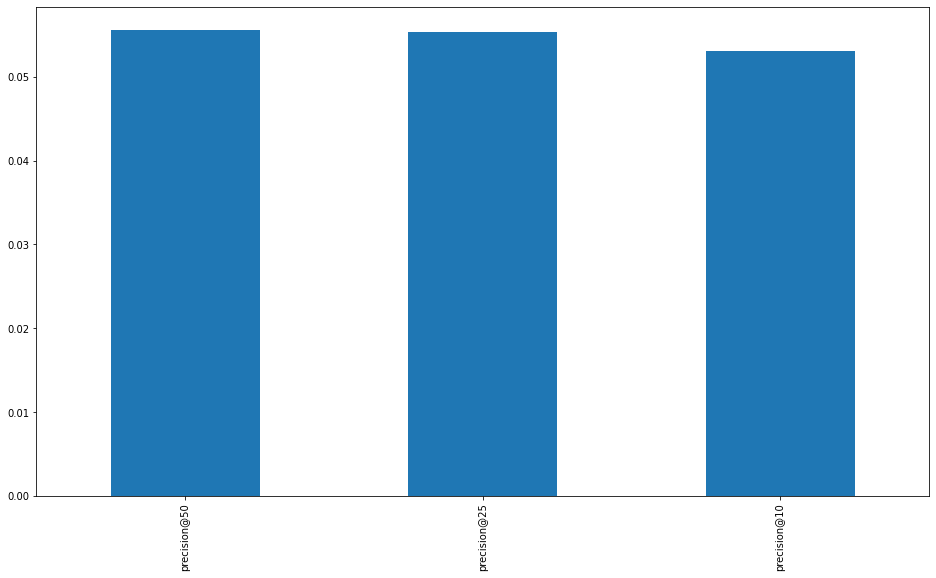

In [ ]:
df_result2[['precision@50','precision@25', 'precision@10']].mean().plot.bar(figsize=(16,9))

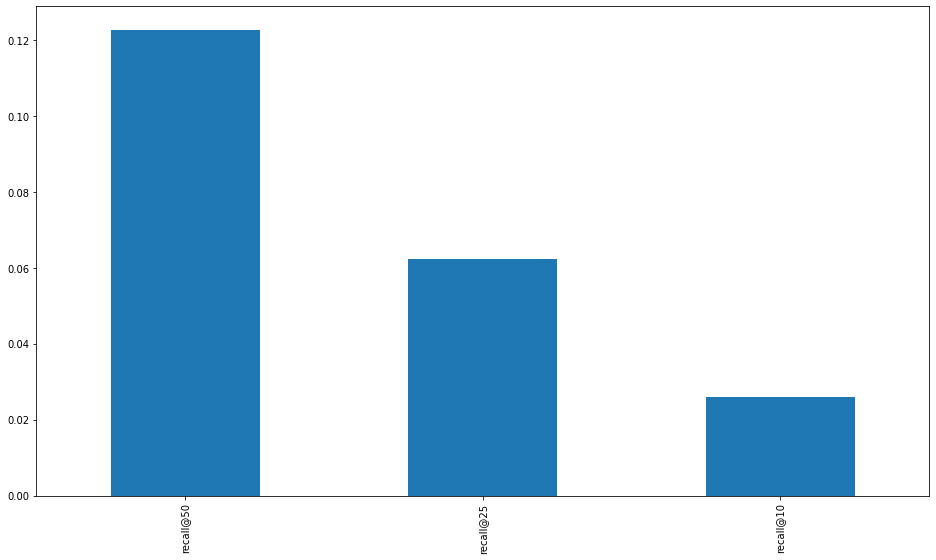

In [ ]:
df_result2[['recall@50','recall@25', 'recall@10']].mean().plot.bar(figsize=(16,9))

In [ ]:
df_result2.tag.values

array(['디즈니', '연애', '유재석', '고막남친', '포근한', '연말', '짝사랑', '운전', '봄바람',
       '잠들기전', '힘', '흥겨운', '신곡', '산책', '듣기좋은', '걸그룹', '파티', '비오는날', '추위',
       '비오는', '불토', '재즈', '이브', 'UK', '연애세포', '여행', '가을밤', '센치한', '록',
       '행복', '배경음악', '감성힙합', '추석', '추억', '지친', '집', '어쿠스틱', '감성곡', '드라이브',
       '고속도로', '신나는', '가을비', '트로트', '눈', '불금', '피아노', '발랄', '성인가요', '댄스',
       '주말', '패션', '우울한', '벚꽃', '날씨', '커피', '노동요', '수록곡', '힘내', '경쾌한',
       '정미애', '따뜻함', '노래', 'OfficialCharts', '헤어짐', '남자아이돌', '팝', '댄스곡',
       '정다경', '여유', '휴식', '새벽', '잔잔함', '2000년대', '나른', '우울', '12월',
       '뉴에이지', '우울할때', '명절', '2019년', '중독성', '엄마아리랑', '인디', '비', '자장가',
       '버스', '스타일', '축하', '까페', '퇴근', '2016', '상큼한', '노래방', '찾아오는DJ',
       'RNBSOUL', '상큼', '청량한', 'EDM', 'deep', '한국힙합', '아픔', '밝은', '혼자',
       '기분전환', '찬양', '아이돌', '부드러운', '눈오는날', '귀르가즘', '여름노래', '댄스댄스', 'bar',
       '크리스마스캐롤', '테라스', 'electronica', '연휴', '봄비', '가을', '북카페', '알앤비',
       '토닥토닥', '장마', '트렌디', '꿀잠', '잔잔', '하우스', '와인', '생일', '국외', 

In [ ]:
df_result2.tag.nunique()

358

In [ ]:
len(['연애', '유재석', '포근한', '연말', '짝사랑', '친구', '운전', '봄바람', '호텔', '잠들기전',
       '러브송', '흥겨운', '산책', '듣기좋은', '걸그룹', '요가', '드라이빙', '안녕', '파티',
       '비오는날', '추위', '감미로운', '재즈', '기억', '이브', 'UK', '추억회상', '여행', '가을밤',
       '센치한', '최신', '배경음악', '추석', '피트니스', '추억', '집', '남자', '살랑살랑', '어쿠스틱',
       '감성곡', '드라이브', '고속도로', '신나는', '가을비', '눈', '불금', '피아노', '연주',
       '성인가요', '댄스', '주말', '패션', '우울한', '벚꽃', '날씨', '커피', '노동요', '경쾌한',
       '나만의Best3', '정미애', '노래', '헤어짐', '팝', '댄스곡', '심쿵', '여유', '휴식', '아기',
       '새벽', 'SWAG', '우울', '침대', '12월', '뉴에이지', '낭만적인', '론뮤직', '공부할때',
       '우울할때', '명절', '2019년', '중독성', '엄마아리랑', '인디', 'DJ', '비', '자장가',
       '버스', '스타일', '까페', '퇴근', '핫한', '상큼한', '노래방', '상큼', 'EDM', '오디오',
       '혼자', '기분전환', 'cafe', '감성자극', '휴양지', '아이돌', '부드러운', '눈오는날', '아련한',
       '여름노래', '댄스댄스', 'electronica', '연휴', '가을', '알앤비', '토닥토닥', '장마',
       '가을감성', '트렌디', '꿀잠', '내마음의사진', '과거', '잔잔', '하우스', '와인', '고백', '신남',
       '봄노래', '쓸쓸', '데이식스', '느낌있는', '성탄절', '불면증', '전곡듣기', '월드', '귀성길',
       '최애곡', '디스코', '달달', '소울', '책읽을때', '슬픔', '운동', '사랑노래', '락', '잔잔한노래',
       '첫눈', '여름밤', '쌀쌀한', '시원한', '저녁', '낮잠', '일렉', '캐롤', '수고', 'kpop',
       '방콕', '혼자있을때', '메리크리스마스', '기분좋은', '포크', '빌로우', '아무로나미에', '꽃',
       '월요병', '분위기', '청량', '페스티벌', '추천곡', '내적댄스', '외로움', '클럽', '즐거운',
       '맑은', '스포츠', '미스터트롯', '열대야', '오르골', '감성발라드', '밤', '시작', '브릿팝',
       'EDMFloor', '빗소리', '트렌드', '조용한', '낙엽', '겨울밤', 'RnB', '2019', '몽환',
       '블랙뮤직', '겨울노래', '겨울', '휴일', '태교', '팝송', '새벽감성', '소나기', '그리움', '공감',
       'dance', '달달한', '신나는노래', '하늘', '그루브', '봄', '퓨전재즈', '회식', '일렉트로니카',
       '잔잔한', '힙합엘이', '이어폰', '힘들때', '설렘', '취향저격', '독서', '명상', '썸', '목소리',
       'TOP20', '내한', '랩', '더위', '송가인', 'Official_Chart', '따듯한', '띵곡들',
       '파워풀', '베스트', '연주곡', '셋리스트', '감성', '엄마', '재즈힙합', '바람', '헬스',
       '운동할때', '동요', '흐린날', '감성적인', '명곡', '감성충전', '임영웅', '집콕', '홍자', '별',
       '커피숍', 'pub', '크리스마스', '바다', '기분업', '안전운전', '봄캐롤', '추억의', '흥폭발',
       '겨울감성', '도시', '어린이집', '숨은명곡', '모닝콜', '꿀맛', '화창한', '라운지', '2000',
       '휴가', 'bgm', '여름휴가', '연인', '비오는날듣기좋은노래', '하루', '슬픈', '헬스장', 'Pop',
       '집중', '눈물', '아침', '두근두근', '즐거움', 'Rock', '차분한', '출근길', '이별', '계절',
       '스트레스', '봄날', '잠', '피크닉', '음색', '달콤', 'OST모음', '다이어트', '추운날', '띵곡',
       '알엔비', '콘서트', '오후', '시험', '트롯', '숙면', 'HOT', '회상', '우산', '대세',
       '싱어송라이터', '캐럴', '취저', '신나는_음악', '꿀성대', '흥', '설레임', '힙합', '애창곡',
       '이별노래', '카페', '매장', '음색깡패', '크리스마스노래', '여자', '스웩', '1990', '미스트롯',
       '2010', '퇴근길', '잠잘때', '공부', '설날', '쓸쓸한', '감각적인', '연주음악', '달콤한',
       '주제곡', '사랑', 'HIPHOPLE', '발라드', '생각', '여름', '힐링', '여자아이돌', '방탄',
       '센치', '커플', '첫사랑', '지하철', '위로', '매장음악', '좋은노래', '가사', '데이트',
       'Acoustic', '유산소', '솔로', '세련된', '비트', '스타일리시', '꿈', '야경', '편안한',
       '일상'])

355

In [ ]:
df_result.sort_values('recall', ascending=False).head(10)

,tag,recall,precision,prediction,true,correct,spent
352,과거,1,0.02,"[107419, 230640, 443439, 189817, 158626, 53679...",[473570],1,2.35757
762,추억의,1,0.02,"[424258, 536799, 158626, 232763, 189817, 70722...",[264701],1,2.37063
780,화창한,1,0.02,"[133156, 37880, 704788, 55638, 662933, 348455,...",[205179],1,2.34576
445,수고,1,0.02,"[704788, 55638, 133156, 348455, 37880, 466984,...",[205179],1,2.32471
891,추운날,1,0.02,"[704788, 561416, 630821, 55638, 133156, 300465...",[205179],1,2.36187
1063,스타일리시,0.666667,0.04,"[568089, 639954, 543752, 704897, 509511, 61106...","[630941, 611069, 6888]",2,2.34518
758,안전운전,0.666667,0.04,"[133156, 55638, 348455, 704788, 37880, 588744,...","[519160, 205179, 203619]",2,2.36292
78,이브,0.6,0.06,"[623728, 168776, 463555, 219438, 690628, 52434...","[362767, 466570, 318767, 582889, 501686]",3,2.3799
252,스타일,0.5,0.04,"[477444, 391192, 568089, 85267, 514777, 585272...","[487867, 654833, 367736, 191915]",2,2.31749
391,귀성길,0.5,0.04,"[637149, 133156, 55638, 704788, 588744, 37880,...","[31529, 117891, 470129, 371783]",2,2.37331


In [ ]:
df_result.sort_values('correct', ascending=False).head(20)

,tag,recall,precision,prediction,true,correct,spent
618,잔잔한,0.00499773,0.22,"[273170, 512654, 408606, 298103, 228821, 14466...","[46284, 423694, 304214, 516838, 695357, 456174...",11,2.36969
250,자장가,0.0718954,0.22,"[118155, 162889, 570349, 264340, 501294, 51265...","[168038, 465449, 364779, 466182, 115008, 27103...",11,2.31401
466,빌로우,0.169811,0.18,"[637149, 668241, 24769, 256923, 159069, 148239...","[526106, 197305, 706129, 527328, 340244, 66397...",9,2.35717
1022,힐링,0.00406137,0.18,"[273170, 218859, 696494, 501294, 29793, 571790...","[145080, 78145, 450107, 55420, 138586, 578471,...",9,2.31159
1012,사랑,0.00506472,0.18,"[64052, 32606, 422077, 487905, 487911, 704788,...","[172757, 393005, 696155, 70185, 224609, 468439...",9,2.31639
633,설렘,0.00873786,0.18,"[487905, 32606, 348455, 225405, 64052, 701557,...","[225510, 204866, 57957, 646785, 564776, 232890...",9,2.3448
215,새벽,0.0043956,0.16,"[169984, 368069, 629217, 121837, 557120, 22882...","[245844, 72634, 356735, 670925, 396220, 428928...",8,2.34957
508,외로움,0.142857,0.16,"[561416, 704788, 144663, 630821, 116573, 35736...","[456665, 77089, 21633, 13142, 278145, 349588, ...",8,2.30641
61,비오는날,0.0117474,0.16,"[202564, 144663, 594592, 193232, 507060, 44811...","[129016, 219565, 37298, 158214, 509169, 424278...",8,2.39888
1027,센치,0.0761905,0.16,"[561416, 144663, 357367, 116573, 630821, 35134...","[298962, 542554, 234462, 610467, 219025, 37666...",8,2.31609


In [ ]:
df_meta[df_meta.id.isin(df_result.loc[61, 'prediction'])]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,gnrs,new_id
2415,"['GN0105', 'GN0101']",20151207,그 곳,2655009,[924434],그 곳 (Feat. 김태홍),['GN0100'],['허준범'],24222,['발라드'],14430
2968,"['GN1807', 'GN1801']",20131218,Simplement Piano (심플먼트 피아노),2222024,[8048],River Flows In You,['GN1800'],['이루마'],29793,['뉴에이지'],17714
6391,['GN0901'],20130315,The 20/20 Experience (Standard Ver.),2178525,[2646],Tunnel Vision,['GN0900'],['Justin Timberlake'],65680,['POP'],37402
9424,"['GN0105', 'GN0101']",20130924,나란놈이란,2201988,[1142],나란놈이란,['GN0100'],['임창정'],95928,['발라드'],52403
10293,['GN0101'],20170126,함께 걷던 길,10033418,[1134286],함께 걷던 길 (With 선진),['GN0100'],['아재'],105140,['발라드'],57055
10488,"['GN0104', 'GN0101']",20060227,Re - Feel,314287,[160080],술이야,['GN0100'],['바이브'],107220,['발라드'],58073
11430,"['GN0501', 'GN0601', 'GN0503', 'GN0606', 'GN05...",20111123,Lo9ve3r4s,2038488,[242988],안아줘,"['GN0500', 'GN0600']",['정준일'],116573,"['인디음악', '록/메탈']",62607
12861,"['GN0401', 'GN0403']",20161228,The 2nd Mini Album `Her`,10026417,[752425],이별,['GN0400'],['폴킴'],130664,['R&B/Soul'],69657
12933,"['GN0501', 'GN0601', 'GN0503', 'GN0606', 'GN05...",20161110,LIFE IS BEAUTY FULL,10013929,[927668],비행운,"['GN0500', 'GN0600']",['문문 (MoonMoon)'],131295,"['인디음악', '록/메탈']",134
14266,"['GN0105', 'GN0101']",20170324,밤편지,10047890,[261143],밤편지,['GN0100'],['아이유'],144663,['발라드'],8126


In [ ]:
df_result['recall'].mean()

0.051855323836241515

In [ ]:
%timeit predicted = all_tag_model.predict(idx2tag[_test_tag_id], k)

1 loop, best of 3: 2.81 s per loop


In [ ]:
all_tag_model.model.save(get_path('All_Model_2'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/All_Model_2/assets


In [ ]:
train = pd.read_csv(get_path("train_v7.csv"))
test = pd.read_csv(get_path("test_v7.csv"))

In [ ]:
pivot_matrix = train.pivot_table('freq',  'tag_id', 'song_id', aggfunc='max')

In [ ]:
pivot_matrix = pivot_matrix.fillna(0)

In [ ]:
df_pivot = pivot_matrix

In [ ]:
# Matrix Factorization
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(pivot_matrix)
matrix

array([[ 0.11829358, -0.16931734, -0.1479459 , ...,  0.07338503,
         0.02511521,  0.01301566],
       [ 0.59023078, -0.49473552, -0.3719707 , ...,  0.30014447,
        -0.24729002,  0.20129794],
       [ 0.55985597, -0.36604425, -0.05855398, ...,  0.01887339,
        -0.19964556, -0.25100695],
       ...,
       [ 0.57351107, -0.74902889, -0.45786467, ..., -0.04034269,
        -0.27384701, -0.19464832],
       [ 0.16725918, -0.13474781,  0.05527333, ...,  0.01717754,
         0.09546117, -0.05798859],
       [ 1.76328539,  0.29240555, -0.27211151, ...,  0.47313108,
         0.15773844, -0.31776044]])

In [ ]:
# 피어슨 상관계수 구하기
import numpy as np

corr = np.corrcoef(matrix)
corr

array([[1.        , 0.60330284, 0.40008019, ..., 0.64388114, 0.45770041,
        0.09074072],
       [0.60330284, 1.        , 0.40657604, ..., 0.7704058 , 0.43946909,
        0.66222948],
       [0.40008019, 0.40657604, 1.        , ..., 0.74453832, 0.72655687,
        0.34011542],
       ...,
       [0.64388114, 0.7704058 , 0.74453832, ..., 1.        , 0.68518184,
        0.49892559],
       [0.45770041, 0.43946909, 0.72655687, ..., 0.68518184, 1.        ,
        0.33522279],
       [0.09074072, 0.66222948, 0.34011542, ..., 0.49892559, 0.33522279,
        1.        ]])

In [ ]:
import math
import scipy
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split

In [ ]:
df_pivot.index.name = 'tags'
df_pivot.columns.name = 'songs'
df_pivot.head()

songs,10,28,30,32,47,54,57,62,64,67,71,93,96,111,113,135,148,149,187,191,195,199,210,224,237,238,249,250,261,265,266,270,280,289,295,305,307,311,339,347,...,707527,707534,707548,707564,707573,707580,707584,707594,707597,707600,707615,707621,707631,707635,707659,707672,707676,707706,707718,707724,707727,707763,707768,707771,707786,707792,707808,707830,707837,707841,707873,707874,707884,707896,707913,707927,707934,707965,707969,707985
tags,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# matrix는 pivot_table 값을 numpy matrix로 만든 것 
matrix = df_pivot.values

# tag_ratings_mean은 tag의 평균 song 개수 
tag_ratings_mean = np.mean(matrix, axis = 1)

# R_user_mean : 사용자-영화에 대해 사용자 평균 평점을 뺀 것.
matrix_tag_mean = matrix - tag_ratings_mean.reshape(-1, 1)

In [ ]:
matrix.shape

(1382, 69627)

In [ ]:
tag_ratings_mean.shape

(1382,)

In [ ]:
# scipy에서 제공해주는 svd.  
# U 행렬, sigma 행렬, V 전치 행렬을 반환.
%time U, sigma, Vt = svds(matrix_tag_mean, k = 12)

CPU times: user 14.1 s, sys: 156 ms, total: 14.3 s
Wall time: 7.29 s


In [ ]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(1382, 12)
(12,)
(12, 69627)


In [ ]:
sigma = np.diag(sigma)

In [ ]:
sigma.shape

(12, 12)

In [ ]:
# U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다. 
# 거기에 + 사용자 평균 rating을 적용한다. 
svd_tag_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + tag_ratings_mean.reshape(-1, 1)


In [ ]:
df_svd_preds = pd.DataFrame(svd_tag_predicted_ratings, columns = df_pivot.columns)
df_svd_preds.head()

songs,10,28,30,32,47,54,57,62,64,67,71,93,96,111,113,135,148,149,187,191,195,199,210,224,237,238,249,250,261,265,266,270,280,289,295,305,307,311,339,347,...,707527,707534,707548,707564,707573,707580,707584,707594,707597,707600,707615,707621,707631,707635,707659,707672,707676,707706,707718,707724,707727,707763,707768,707771,707786,707792,707808,707830,707837,707841,707873,707874,707884,707896,707913,707927,707934,707965,707969,707985
0,0.000292,0.000460,0.004196,0.000447,0.001517,-0.000368,0.000540,0.001381,0.000294,0.000483,0.005188,0.001584,0.000485,0.000434,-0.000020,0.000216,-0.000286,0.000331,0.000526,0.000337,0.000066,0.000378,0.000042,0.000171,0.000197,0.002815,0.000787,-0.003784,0.000249,0.000384,0.000257,0.001515,0.000497,0.002842,0.000241,0.000365,0.000677,0.003628,0.000109,0.000521,...,0.000526,0.000400,0.000039,0.002155,0.011763,0.000430,0.000230,0.000354,0.000300,0.001044,0.001630,0.000960,0.000327,0.002736,0.000165,0.000540,0.002849,0.000413,0.000351,0.000643,-0.000047,0.000211,0.001690,0.000619,0.000217,-0.000285,0.000272,-0.000955,0.005499,0.000044,0.002379,0.000273,0.000882,0.000342,-0.000191,0.000184,0.000563,0.002346,0.000578,0.000402
1,0.005380,0.004719,0.007198,0.002969,0.004053,0.004607,0.003386,-0.000178,0.001882,0.002256,0.008697,0.006938,0.003462,0.002520,0.002963,0.001571,0.006027,0.002388,0.004795,0.003646,0.000798,0.002952,0.005167,0.002100,0.003178,0.007006,0.003263,0.014205,0.002505,0.002080,0.002608,0.003694,0.003260,0.007993,0.001733,0.002513,0.005599,0.012936,0.002422,0.003126,...,0.002713,0.004516,0.004176,0.013904,0.021751,0.002716,0.002401,0.003471,0.002226,0.004478,0.004827,0.020717,0.003122,0.013768,0.001742,0.002678,0.010560,0.002356,0.002949,-0.002261,-0.002246,0.000511,0.005057,0.002984,0.000250,0.001873,0.003130,-0.003209,0.006002,0.007457,0.004944,0.001102,0.004229,0.002462,-0.003320,0.005892,0.003271,0.005160,0.003199,0.003284
2,0.003195,0.003318,0.004486,0.003237,0.002363,0.000958,0.003263,0.000248,0.002793,0.003497,0.022929,0.003449,0.003213,0.003509,0.004075,0.004127,0.002307,0.005359,0.002873,0.003000,0.003602,0.003007,0.003900,0.006146,0.003763,0.002952,0.002803,0.002166,0.003223,0.002380,0.003674,0.002086,0.003872,0.004176,0.004184,0.002292,0.003232,0.003645,0.004291,0.002713,...,0.003687,0.003745,0.002103,-0.003159,0.016844,0.001926,0.003309,0.002514,0.002102,0.002303,0.007067,-0.008595,0.003350,0.007332,0.003960,0.004070,0.003360,0.004671,0.002982,-0.012067,0.005697,0.004307,0.004856,0.004600,0.002143,0.005352,0.005151,0.010352,-0.001951,0.001019,0.005484,0.003170,0.003787,0.003638,0.007845,0.003860,0.004187,0.002051,0.003416,0.003591
3,0.008962,0.014155,0.184001,-0.026768,0.001482,0.646668,0.007416,-0.060866,0.078157,-0.090177,0.836412,-0.000977,0.077535,0.005280,0.176344,0.119186,0.276622,-0.032772,0.011446,0.001375,0.070142,0.017092,0.216181,0.103517,0.055244,0.034048,0.001938,6.930996,-0.011927,-0.013292,0.002978,-0.002277,0.033774,0.288392,-0.038675,-0.010262,0.015279,1.839212,0.076656,0.008652,...,0.018101,-0.007901,0.106200,0.407841,0.068972,0.000152,-0.003996,0.000632,0.033879,0.010121,0.003133,0.163159,0.006949,0.191769,0.063579,0.181897,0.065224,0.079603,-0.010041,0.595631,0.012367,0.046674,0.010919,0.017907,0.026794,0.586503,0.011548,0.085322,-0.050452,0.038904,0.002351,0.053441,0.035852,-0.004338,0.259648,0.015250,0.003827,-0.007671,0.008539,0.004814
4,0.001441,0.000877,0.014518,0.001090,-0.000236,0.004145,0.000738,-0.000328,0.001262,0.002447,-0.005894,-0.001029,0.003579,0.002005,0.001142,0.001001,0.001908,0.002040,0.001002,0.000837,0.012129,0.001659,0.003148,0.003333,0.001173,0.004241,0.000489,0.036145,0.001105,0.000348,0.002632,-0.000300,0.000157,0.008001,0.001119,0.001146,0.004973,0.005463,0.002184,0.002029,...,0.002960,0.000648,0.002328,0.008922,0.011827,0.001793,0.000838,0.003090,0.001559,0.005048,0.002399,0.012197,0.001068,-0.001150,0.001345,0.000352,0.007883,0.001837,0.000965,0.008662,0.000419,0.000931,0.010680,0.002676,0.001840,0.003561,0.001702,0.000759,-0

In [ ]:
df_svd_preds.shape

(1382, 69627)

In [ ]:
k = 50
def svd_recommender(tag, df_svd_preds=df_svd_preds, k=50):
  return df_svd_preds.loc[tag2idx.get(tag), :].sort_values(ascending = False).head(k).index.tolist()

In [ ]:
predicted_songs.values

array([326204, 695032, 358186, 387859, 112399, 468494,   5049, 640657,
       422176, 519391, 238699, 521739, 567990, 307896,    645, 587738,
       600640, 186192, 603694, 318487, 262202, 280293, 117323, 188996,
        62574, 341513, 304532, 414226, 232606, 226670,  53760, 259163,
       335077,  61771, 187149, 484367,  10445, 224921,  89756, 210432,
       456704, 164891, 562860, 582252, 136428,  12851, 152394, 510190,
       359783, 509998])

In [ ]:
df_pivot

songs,10,28,30,32,47,54,57,62,64,67,71,93,96,111,113,135,148,149,187,191,195,199,210,224,237,238,249,250,261,265,266,270,280,289,295,305,307,311,339,347,...,707527,707534,707548,707564,707573,707580,707584,707594,707597,707600,707615,707621,707631,707635,707659,707672,707676,707706,707718,707724,707727,707763,707768,707771,707786,707792,707808,707830,707837,707841,707873,707874,707884,707896,707913,707927,707934,707965,707969,707985
tags,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1378,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_tags = ['디즈니', '연애', '유재석', '고막남친', '포근한', '연말', '짝사랑', '운전', '봄바람',
       '잠들기전', '힘', '흥겨운', '신곡', '산책', '듣기좋은', '걸그룹', '파티', '비오는날', '추위',
       '비오는', '불토', '재즈', '이브', 'UK', '연애세포', '여행', '가을밤', '센치한', '록',
       '행복', '배경음악', '감성힙합', '추석', '추억', '지친', '집', '어쿠스틱', '감성곡', '드라이브',
       '고속도로', '신나는', '가을비', '트로트', '눈', '불금', '피아노', '발랄', '성인가요', '댄스',
       '주말', '패션', '우울한', '벚꽃', '날씨', '커피', '노동요', '수록곡', '힘내', '경쾌한',
       '정미애', '따뜻함', '노래', 'OfficialCharts', '헤어짐', '남자아이돌', '팝', '댄스곡',
       '정다경', '여유', '휴식', '새벽', '잔잔함', '2000년대', '나른', '우울', '12월',
       '뉴에이지', '우울할때', '명절', '2019년', '중독성', '엄마아리랑', '인디', '비', '자장가',
       '버스', '스타일', '축하', '까페', '퇴근', '2016', '상큼한', '노래방', '찾아오는DJ',
       'RNBSOUL', '상큼', '청량한', 'EDM', 'deep', '한국힙합', '아픔', '밝은', '혼자',
       '기분전환', '찬양', '아이돌', '부드러운', '눈오는날', '귀르가즘', '여름노래', '댄스댄스', 'bar',
       '크리스마스캐롤', '테라스', 'electronica', '연휴', '봄비', '가을', '북카페', '알앤비',
       '토닥토닥', '장마', '트렌디', '꿀잠', '잔잔', '하우스', '와인', '생일', '국외', '고백',
       '신남', '봄노래', '쓸쓸', '얼터너티브', '느낌있는', '성탄절', '브금', '불면증', '귀성길',
       '에이핑크', '디스코', '인기', '달달', '소울', '책읽을때', '슬픔', '운동', '사랑노래', '락',
       '잔잔한노래', '여름밤', '쌀쌀한', '시원한', '저녁', '낮잠', '일렉', '캐롤', '방콕',
       '메리크리스마스', '기분좋은', '따뜻하게', '빌로우', '아무로나미에', '장르구분없이', '월요병', '분위기',
       '청량', '페스티벌', '추천곡', '내적댄스', '국힙', '외로움', '클럽', '즐거운', '맑은', '스포츠',
       '열대야', '오르골', '감성발라드', '밤', '시작', '브릿팝', '산뜻한', 'EDMFloor', '빗소리',
       '쓸쓸함', '조용한', '낙엽', '겨울밤', '좋아요', '2019', '몽환', '블랙뮤직', '겨울노래',
       '겨울', '휴일', '태교', '팝송', '새벽감성', '바캉스', '그리움', '추천', 'Lounge',
       '플레이리스트', 'dance', '달달한', '신나는노래', '하늘', 'Instrumental', '그루브',
       '치유', '봄', '퓨전재즈', '회식', '일렉트로니카', '잔잔한', '힙합엘이', '힙한', '힘들때',
       '설렘', '취향저격', '독서', '썸', '차분', '목소리', '마음', '내한', '랩', '더위', '따듯한',
       '띵곡들', '베스트', '봄나들이', '인디팝', '연주곡', '셋리스트', '감성', '장윤정', '후회',
       '바람', '헬스', '지칠때', '흐린날', '감성적인', '유산슬', '임영웅', '집콕', '에너지',
       '몽환적인', 'Christmas', '해외일렉트로니카', '크리스마스', '바다', '케이팝', '기분업',
       '흥폭발', '겨울감성', '어린이집', '숨은명곡', 'OST', '2000', '고막여친', '춤', '휴가',
       'bgm', '트랩', '연인', '비오는날듣기좋은노래', '하루', '가족', '슬픈', 'Pop', '집중',
       '눈물', '아침', '카페뮤직', '두근두근', 'Rock', '차분한', '출근길', '이별', 'house',
       '기분', '스트레스', '봄날', '잠', 'ballad', '음색', '달콤', '인디음악', '기타',
       '다이어트', '띵곡', '떼창', '오후', '시험', '숙면', '회상', '대세', '캐럴', '취저',
       '달달한노래', '꿀성대', '희망', '팝송모음', '흥', '설레임', '힙합', '애창곡', '카페', '매장',
       '음색깡패', '크리스마스노래', '스웩', '오늘', '음악', '1990', '신나는음악', '유니크', '퇴근길',
       '신나', '잠잘때', '공부', '설날', '힘이_나는', '달콤한', '주제곡', '사랑', '발라드', '생각',
       '여름', '힐링', '여자아이돌', '방탄', '센치', '고백송', '커플', '첫사랑', '조깅', '지하철',
       '위로', '매장음악', '좋은노래', '가사', '데이트', '유산소', '트로피컬', '리드미컬', '솔로',
       '세련된', '비트', '스타일리시', '야경', '나들이', '편안한', '휘트니스', '영국', '일상']

In [ ]:
%time predictions = {_tag: svd_recommender(_tag) for _tag in test_tags}

CPU times: user 2.88 s, sys: 23.7 ms, total: 2.9 s
Wall time: 2.91 s


In [ ]:
2900 / 358

8.100558659217876

In [ ]:
# predictions[611]

In [ ]:
df_svd_result = df_result2[['tag', 'true']].copy()

In [ ]:
df_svd_result['result'] = df_svd_result.tag.map(lambda x: predictions.get(x))

In [ ]:
df_svd_result

,tag,true,result
0,디즈니,"[262430, 157900, 278849, 638488, 320447, 27133...","[326204, 695032, 358186, 387859, 112399, 51939..."
1,연애,"[565629, 26083, 506798, 701557, 284180, 471691...","[132994, 133143, 650494, 293236, 348200, 61093..."
2,유재석,"[318781, 23443, 299831, 183563, 543264]","[205179, 650494, 704707, 518420, 93143, 130199..."
3,고막남친,"[10961, 144663, 318871, 616212, 635425, 23605,...","[144663, 640657, 205179, 650494, 543371, 35736..."
4,포근한,"[273170, 705853, 96310, 651331, 207232, 605317...","[696494, 144663, 650494, 205179, 132994, 35736..."
...,...,...,...
353,나들이,"[475142, 383040, 416950, 622923, 173798, 30632...","[650494, 132994, 205179, 293236, 457124, 13314..."
354,편안한,"[176125, 516653, 360221, 64052, 160291, 254577...","[696494, 273170, 126656, 571790, 599022, 52192..."
355,휘트니스,"[315611, 231154, 117385, 701606, 256791, 36013...","[205179, 704707, 518420, 130199, 699874, 93143..."
356,영국,"[489432, 654511, 347872, 239108, 260400, 34383...","[493762, 581799, 360825, 24087, 195174, 217365..."


In [ ]:
df_svd_result['k50'] = [np.intersect1d(pred, true).shape[0] for pred, true in zip(df_svd_result.result, df_svd_result.true)]
df_svd_result['k25'] = [np.intersect1d(pred[:25], true).shape[0] for pred, true in zip(df_svd_result.result, df_svd_result.true)]
df_svd_result['k10'] = [np.intersect1d(pred[:10], true).shape[0] for pred, true in zip(df_svd_result.result, df_svd_result.true)]

df_svd_result['recall@50'] = df_svd_result.k50 / df_svd_result.true.map(lambda x: len(x))
df_svd_result['recall@25'] = df_svd_result.k25 / df_svd_result.true.map(lambda x: len(x))
df_svd_result['recall@10'] = df_svd_result.k10 / df_svd_result.true.map(lambda x: len(x))

df_svd_result['precision@50'] = df_svd_result.k50 / 50
df_svd_result['precision@25'] = df_svd_result.k25 / 25
df_svd_result['precision@10'] = df_svd_result.k10 / 10

In [ ]:
df_svd_result.mean()

k50             3.650838
k25             2.055866
k10             0.980447
recall@50       0.122663
recall@25       0.076408
recall@10       0.048954
precision@50    0.073017
precision@25    0.082235
precision@10    0.098045
dtype: float64

In [ ]:
df_svd_result.to_json(get_path('svd_result_final.json'))

In [ ]:
df_svd_result.sort_values('k50', ascending=False).head(50)

,tag,true,result,k50,k25,k10,recall@50,recall@25,recall@10,precision@50,precision@25,precision@10
43,눈,"[582252, 631042, 199262, 500031, 374743, 23260...","[326204, 695032, 519391, 358186, 640657, 38785...",15,10,3,0.172414,0.114943,0.034483,0.30,0.40,0.3
341,매장음악,"[170317, 162551, 633618, 671154, 199390, 61890...","[519391, 205179, 144663, 493762, 273170, 58179...",15,7,3,0.017084,0.007973,0.003417,0.30,0.28,0.3
297,회상,"[198592, 107916, 414221, 622548, 55531, 106990...","[116573, 38261, 509998, 367963, 366786, 582252...",14,10,3,0.016413,0.011723,0.003517,0.28,0.40,0.3
198,새벽감성,"[613497, 8980, 280349, 325363, 573294, 543371,...","[144663, 357367, 543371, 174749, 368069, 35134...",13,7,2,0.087838,0.047297,0.013514,0.26,0.28,0.2
354,편안한,"[176125, 516653, 360221, 64052, 160291, 254577...","[696494, 273170, 126656, 571790, 599022, 52192...",13,6,2,0.069892,0.032258,0.010753,0.26,0.24,0.2
336,커플,"[702912, 187773, 618541, 495821, 62736, 610933...","[132994, 133143, 650494, 293236, 348200, 61093...",12,7,2,0.352941,0.205882,0.058824,0.24,0.28,0.2
296,숙면,"[628, 683918, 608545, 47912, 422987, 312852, 2...","[696494, 273170, 126656, 571790, 29793, 52192,...",12,4,1,0.206897,0.068966,0.017241,0.24,0.16,0.1
142,달달,"[565629, 177617, 285079, 586591, 668341, 53191...","[132994, 133143, 348200, 610933, 293236, 65049...",12,4,1,0.081633,0.027211,0.006803,0.24,0.16,0.1
74,우울,"[199500, 579717, 405400, 231274, 296674, 39982...","[144663, 357367, 174749, 543371, 116573, 36806...",12,7,4,0.063158,0.036842,0.021053,0.24,0.28,0.4
218,힘들때,"[223981, 10961, 488448, 35713, 156278, 231659,...","[418935, 144663, 531820, 366786, 118049, 36806...",12,7,4,0.230769,0.134615,0.076923,0.24,0.28,0.4


In [ ]:
df_result2.sort_values('k50', ascending=False).tail(50)

,tag,recall,precision,prediction,true,correct,spent,k50,k25,k10,recall@50,recall@25,recall@10,precision@50,precision@25,precision@10
160,따뜻하게,0.333333,0.02,"[704788, 55638, 415671, 630821, 78949, 561416,...","[213019, 78949, 116573]",1,2.44176,1,1,1,0.333333,0.333333,0.333333,0.02,0.04,0.1
155,일렉,0.00383142,0.02,"[382796, 221419, 17843, 148092, 582373, 509009...","[60024, 569107, 686912, 180779, 315699, 550567...",1,2.43745,1,1,0,0.00383142,0.003831,0.000000,0.02,0.04,0.0
189,좋아요,0.0833333,0.02,"[521852, 676786, 133156, 595974, 561416, 64327...","[667123, 219225, 97761, 698883, 144663, 541212...",1,2.42634,1,1,0,0.0833333,0.083333,0.000000,0.02,0.04,0.0
190,2019,0.0909091,0.02,"[133156, 55638, 684562, 365276, 205179, 630821...","[535791, 205179, 565112, 432499, 527937, 32499...",1,2.62918,1,1,1,0.0909091,0.090909,0.090909,0.02,0.04,0.1
191,몽환,0.0121951,0.02,"[199485, 446008, 121837, 389636, 211653, 68172...","[624640, 316407, 616166, 353471, 126783, 63624...",1,2.46337,1,0,0,0.0121951,0.000000,0.000000,0.02,0.00,0.0
192,블랙뮤직,0.0526316,0.02,"[259311, 179443, 480984, 395189, 511999, 20361...","[565326, 214681, 264902, 47214, 555342, 431773...",1,2.51234,1,0,0,0.0526316,0.000000,0.000000,0.02,0.00,0.0
152,시원한,0.00990099,0.02,"[148092, 704707, 112260, 130199, 263588, 66419...","[566926, 436561, 209953, 235188, 409058, 17541...",1,2.50086,1,1,0,0.00990099,0.009901,0.000000,0.02,0.04,0.0
130,신남,0.1,0.02,"[133156, 278565, 364442, 263588, 24087, 429152...","[176386, 205179, 704707, 133330, 410113, 17523...",1,2.39502,1,0,0,0.1,0.000000,0.000000,0.02,0.00,0.0
128,국외,0.142857,0.02,"[55638, 133156, 240333, 516215, 680366, 415671...","[98832, 524652, 261601, 5684, 309112, 116877, ...",1,2.42748,1,1,0,0.142857,0.142857,0.000000,0.02,0.04,0.0
127,생일,0.142857,0.02,"[179443, 27945, 545014, 240583, 497276, 554057...","[362228, 536799, 36564, 377700, 402259, 156298...",1,2.46677,1,0,0,0.142857,0.000000,0.000000,0.02,0.00,0.0
